In [1]:
%matplotlib inline
#from geostatsmodels import utilities, kriging, variograms, model, geoplot
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform, cdist
import statsmodels.formula.api as sm

In [2]:
from __init__ import *
from rain import *
from common import *

In [3]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

In [4]:
%load_ext autoreload

In [5]:
%aimport common
%aimport rain

In [6]:
def get_fit(df, col, latlon=True, plot=False):
    df = df[['lon', 'lat', col]].dropna(how='any')
    df.columns = ['lon', 'lat', 'col']
    result = sm.ols(formula="col ~ lon + lat", data=df).fit()
    fit = result.params['Intercept'] + result.params['lon']*df.lon +result.params['lat']*df.lat
    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        for l, ax in zip(['lon', 'lat'], axes):
            ax.scatter(x=df[l], y=df.col)
            ax.scatter(df[l], fit, c='r')
            ax.set_ylabel('Rain Rate (mm/hr)')
            ax.set_xlabel(l)
            ax.set_title('Trend in ' + l)
    return fit

#### Rainiest

In [7]:
rg.get_rainiest(10, time_step='1H', base=0)
z = rg.rainiest[:]

#### Specific high POT times

In [226]:
df = pd.read_csv(path+'The flashiest watersheds in St. Louis_1122.txt', header=None,
                 nrows=20, skiprows=[0,7,14,21], delim_whitespace=True,parse_dates=True)
a=[]
for i in range(len(df)):
    a.append(pd.datetime(df.loc[i,0], df.loc[i,1], df.loc[i,2], df.loc[i,3], df.loc[i,4]))

tt = [t for t in a if rg.rate.index[0] < t < rg.rate.index[-1]]

z = rg.ll
for t in tt:
    z = z.join(rg.rate.loc[t-pd.DateOffset(hours=3):t+pd.DateOffset(hours=1)].transpose())
z = z[z.lat >-200]

#### Either way, do some tweaking

In [227]:
z.X = z.X -z.X.min()
z.Y = z.Y -z.Y.min()

res = z[range(5)]
for col in z.columns[5:]:
    fit = get_fit(z, col)
    res = res.join(pd.DataFrame({col: z[col]-fit+z[col].mean()}))

zeros = [col for col in res.columns[5:] if res[col].mean()==0]
res = res.drop(zeros, axis=1)

#### Wanna check out what you've got?


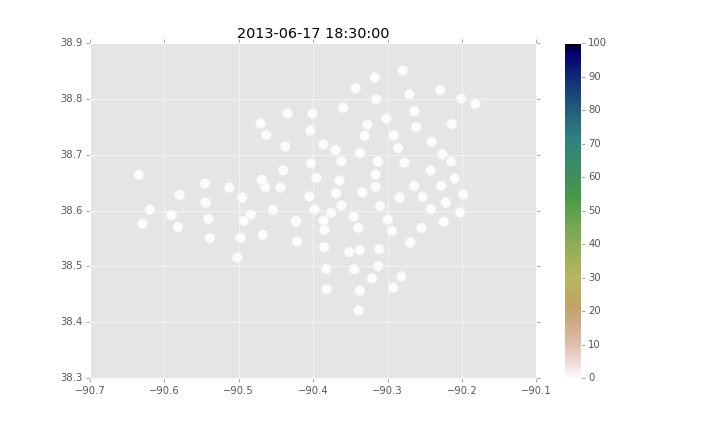
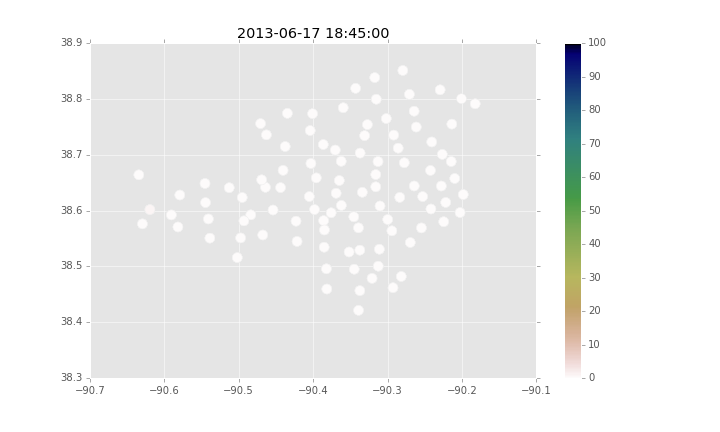
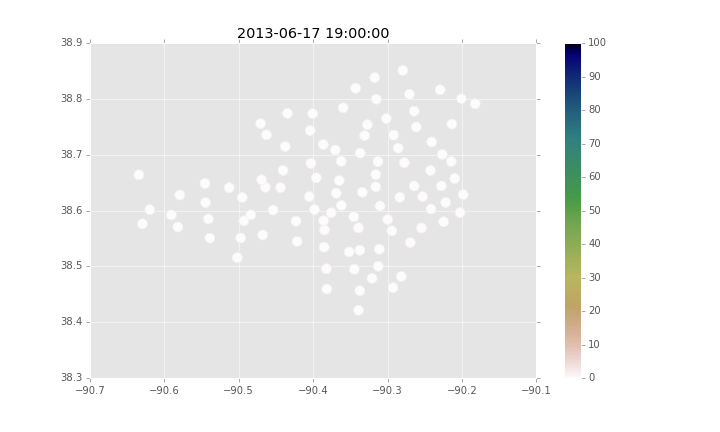
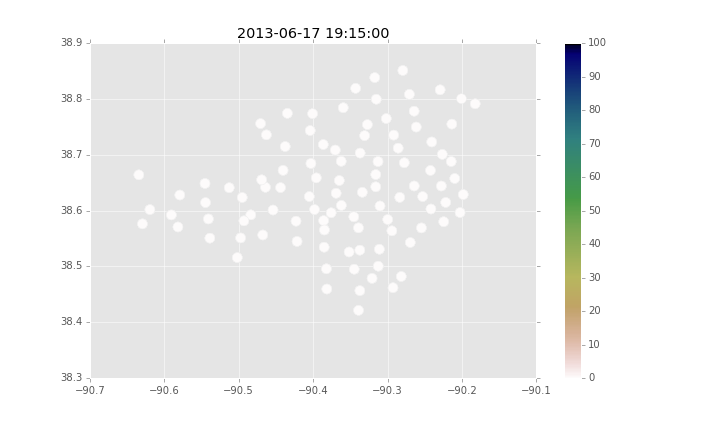
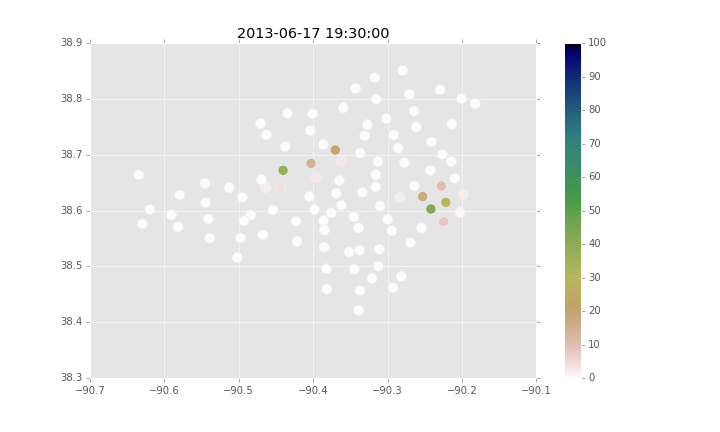
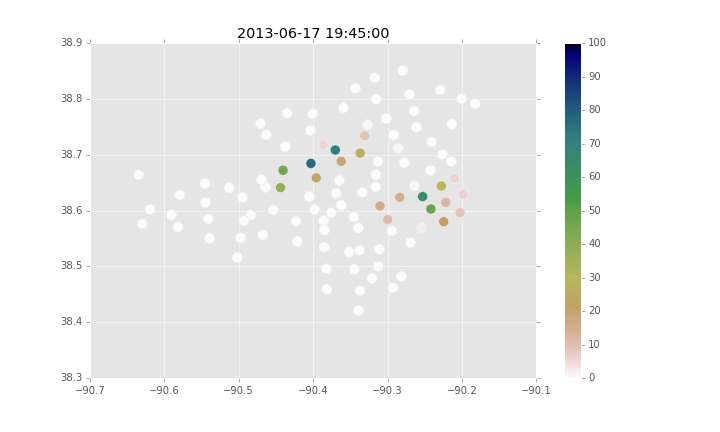
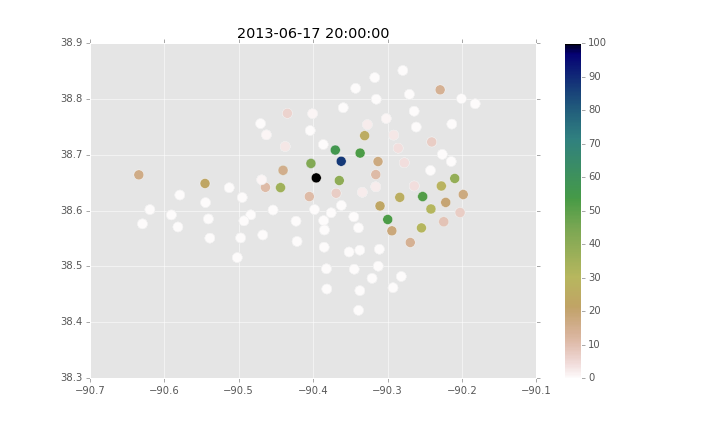
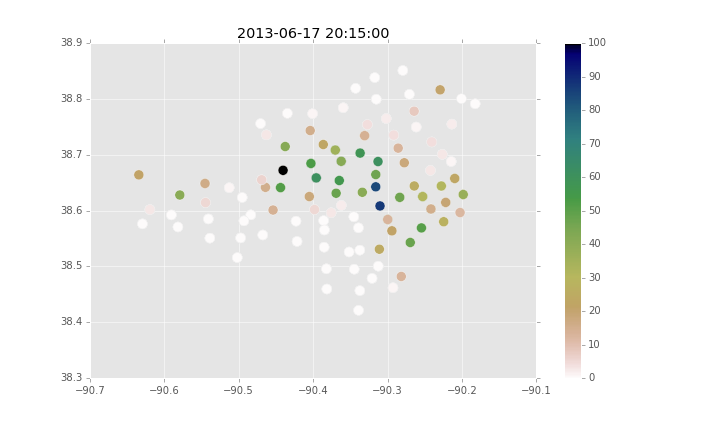
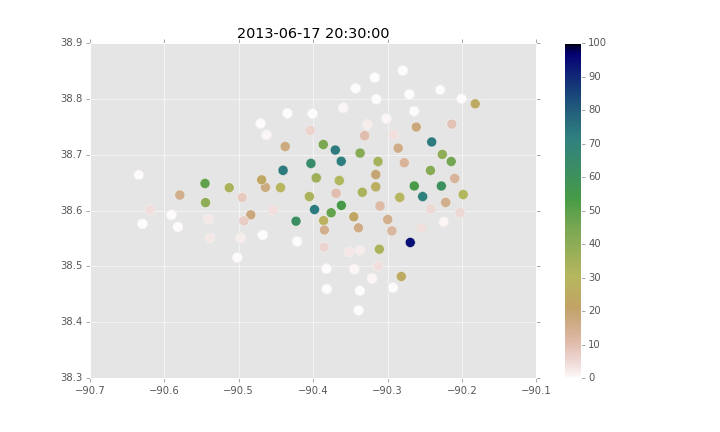
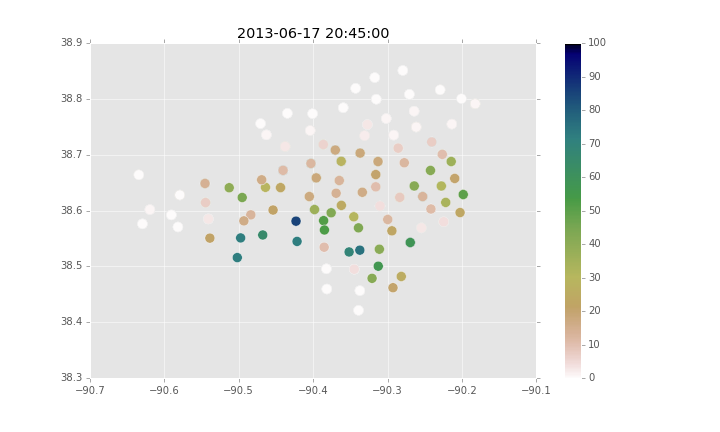
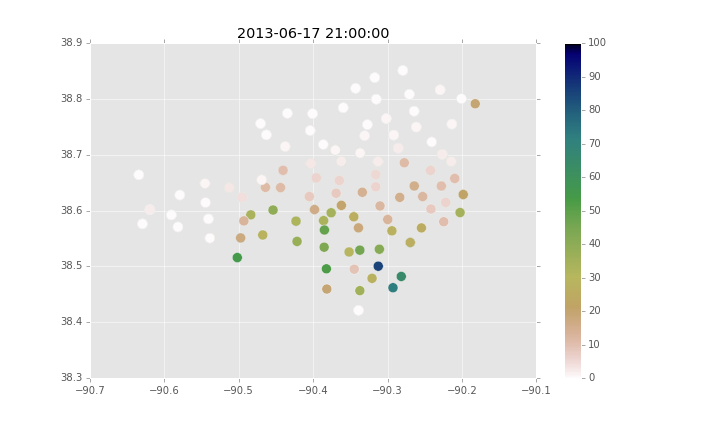
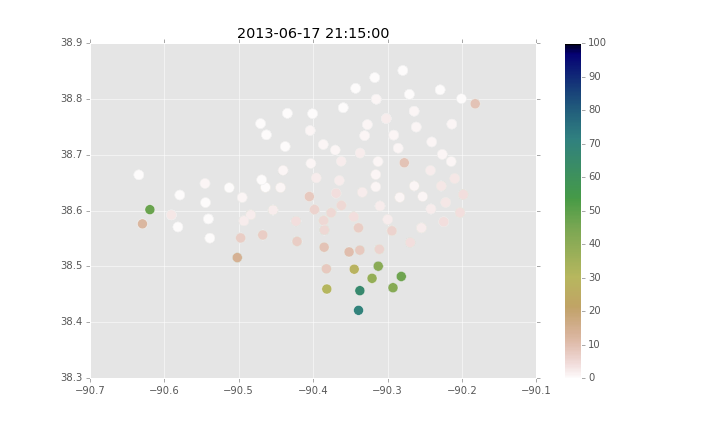
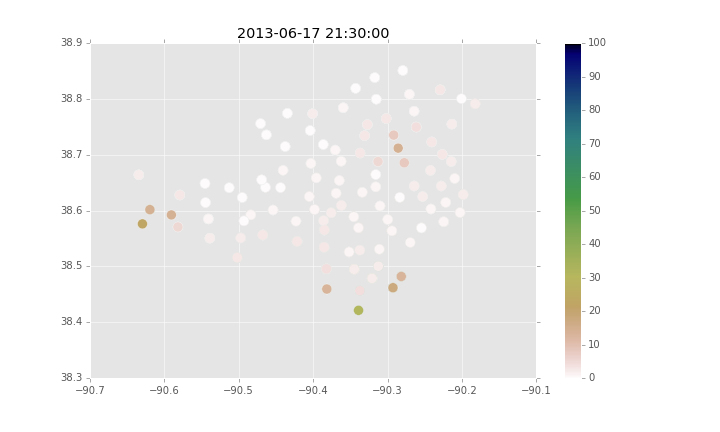
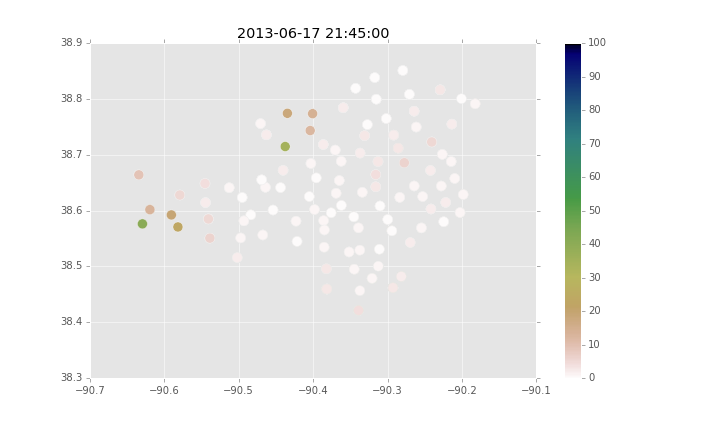
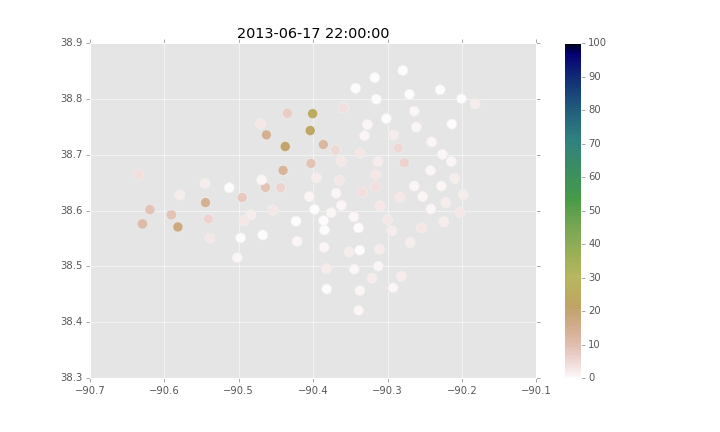
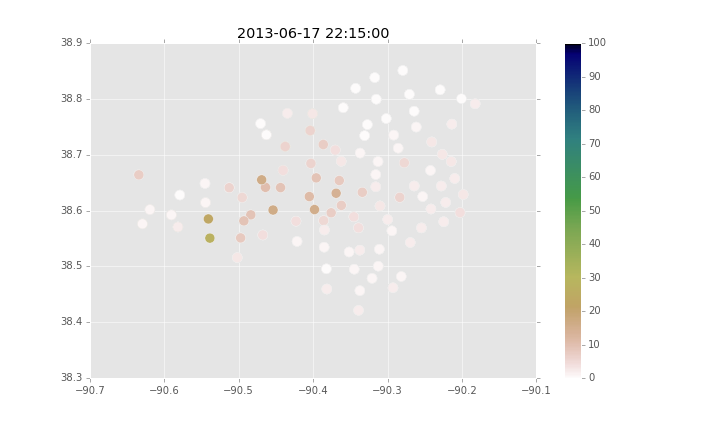
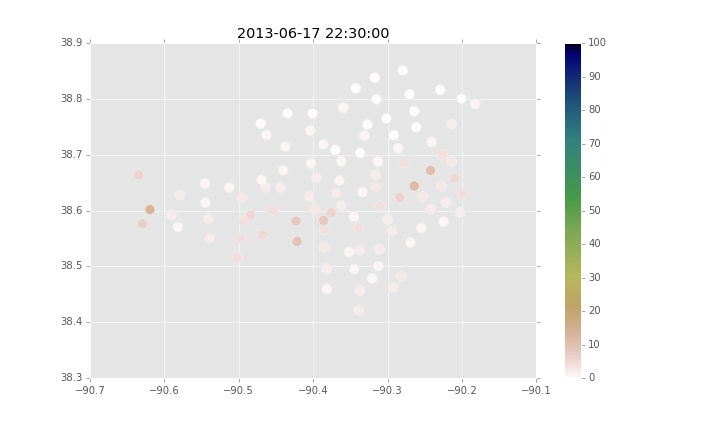
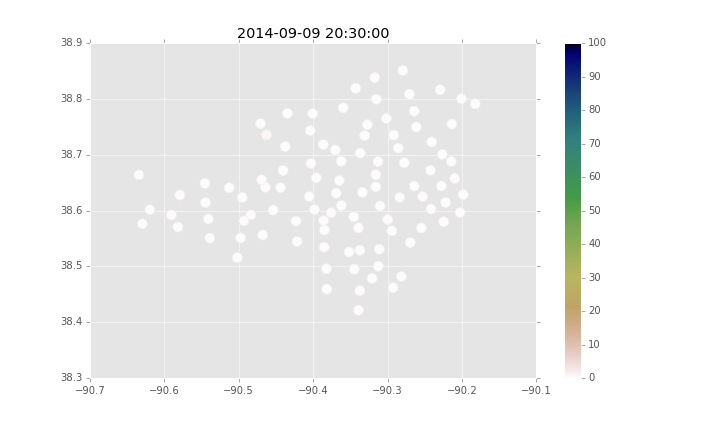
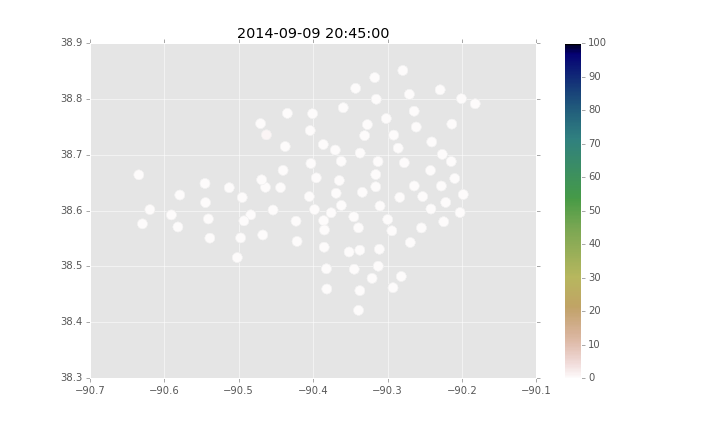
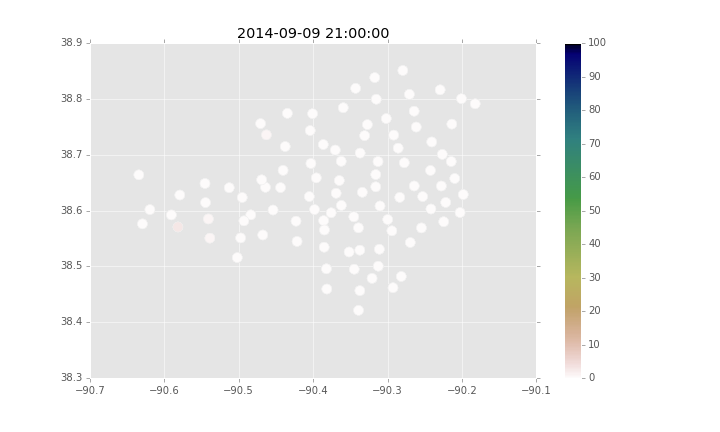
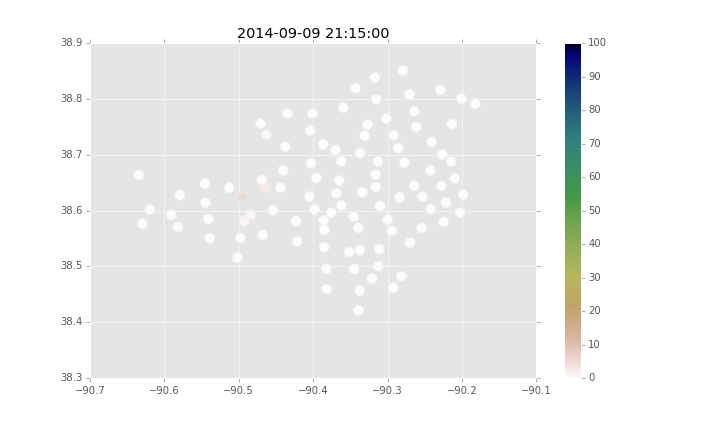
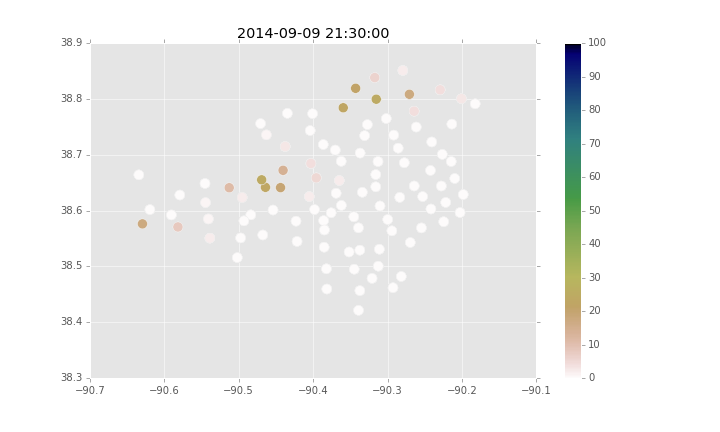
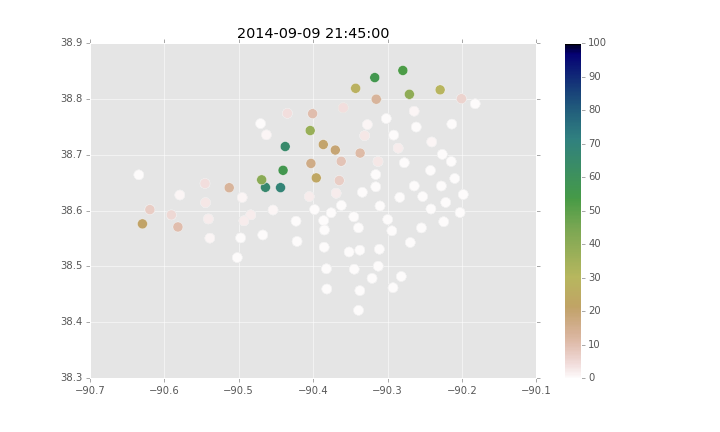
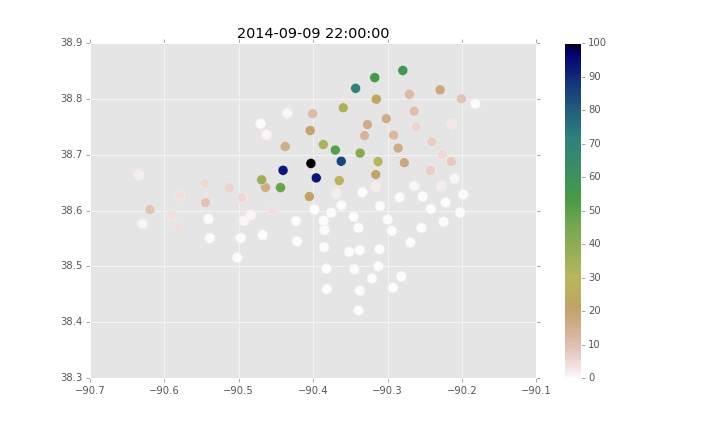
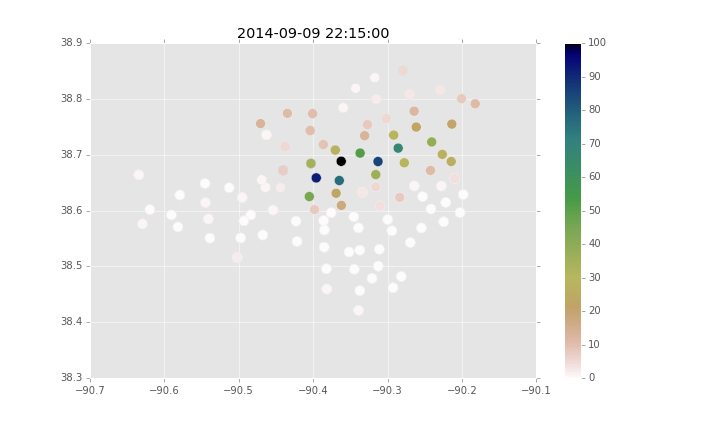
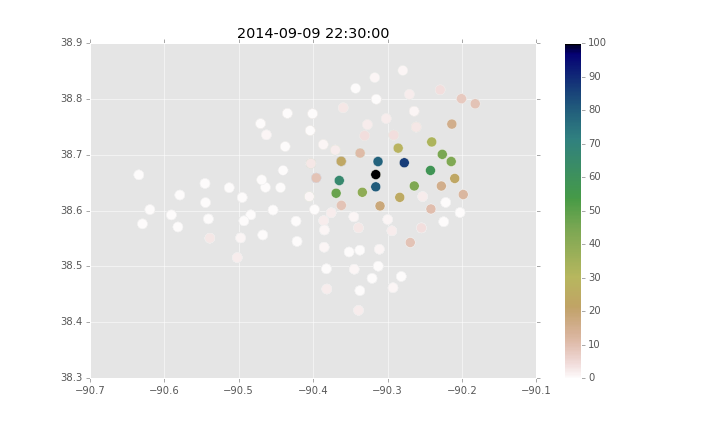
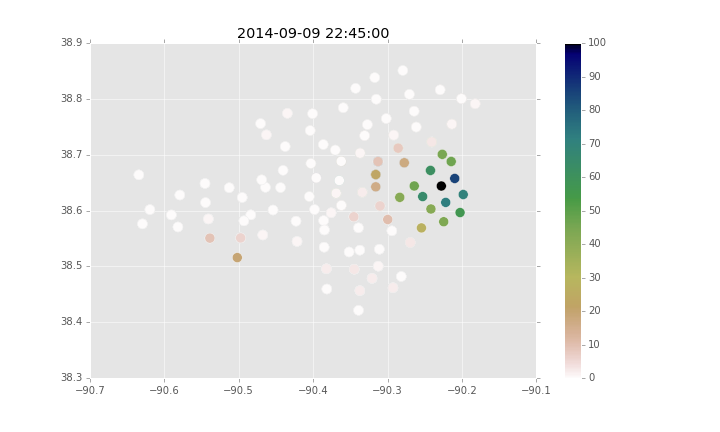
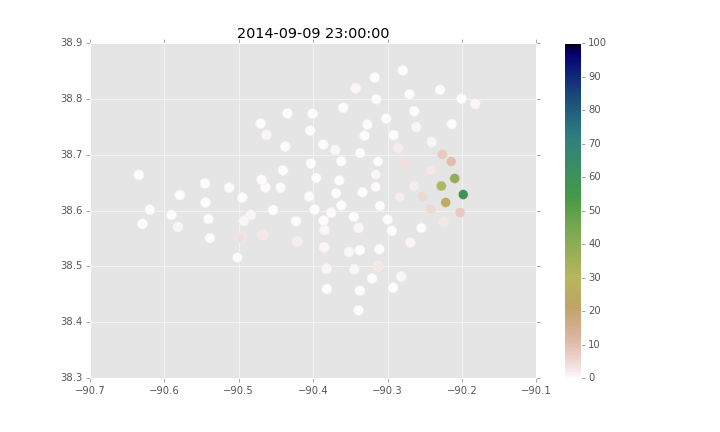
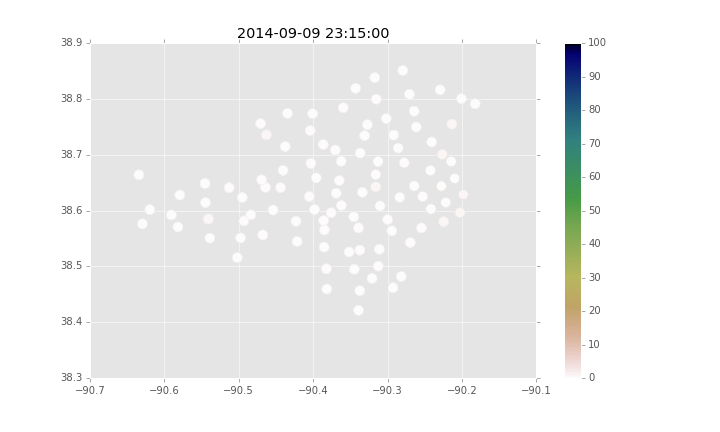
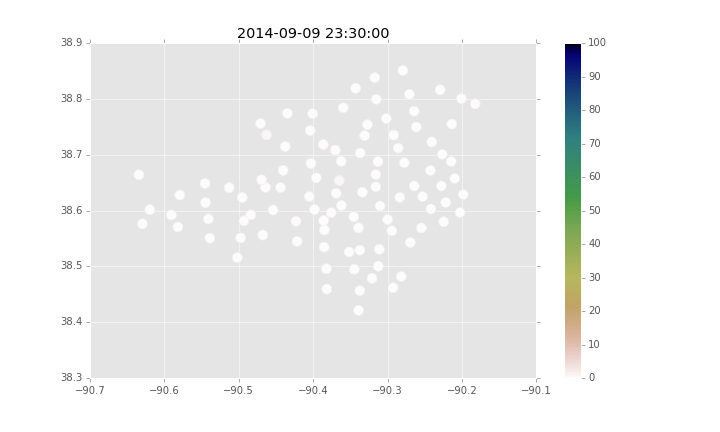
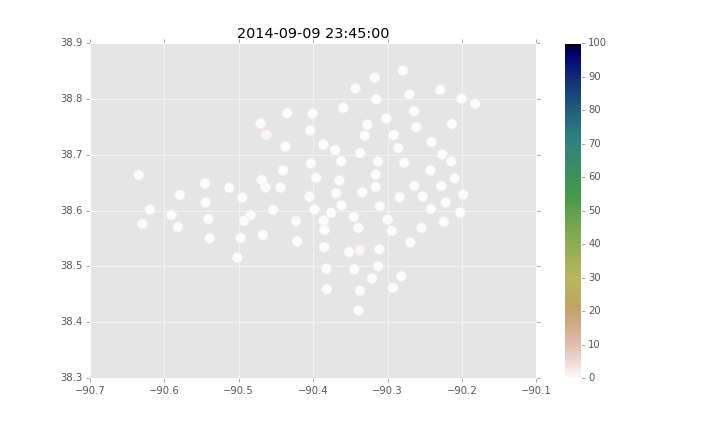
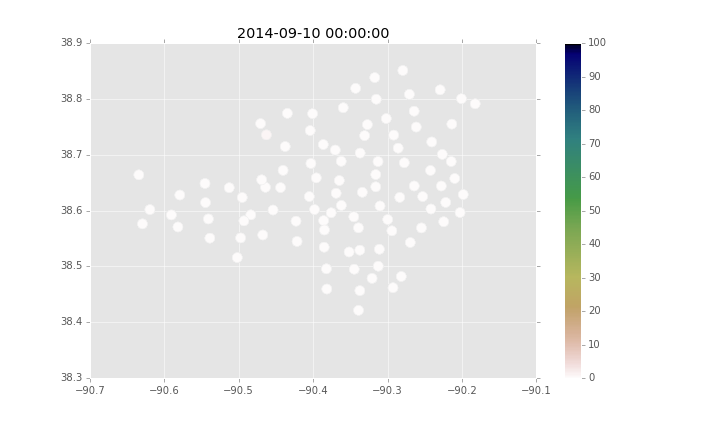
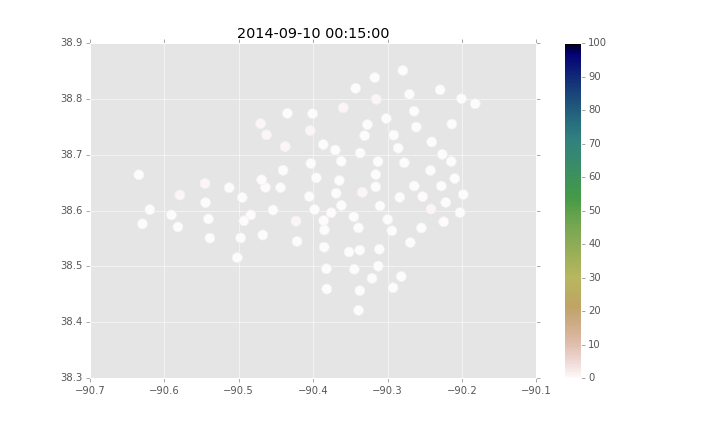
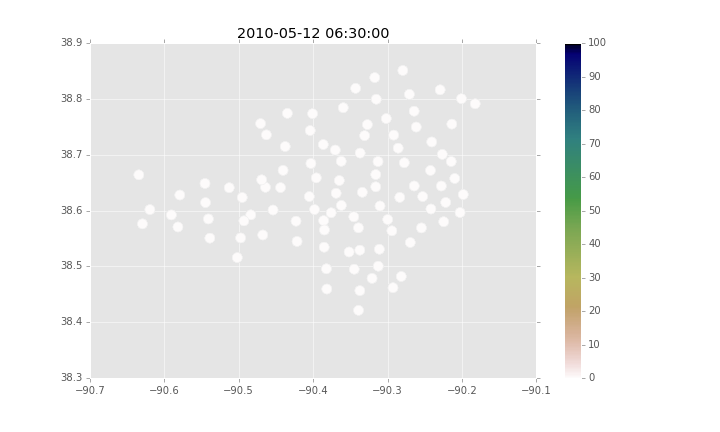
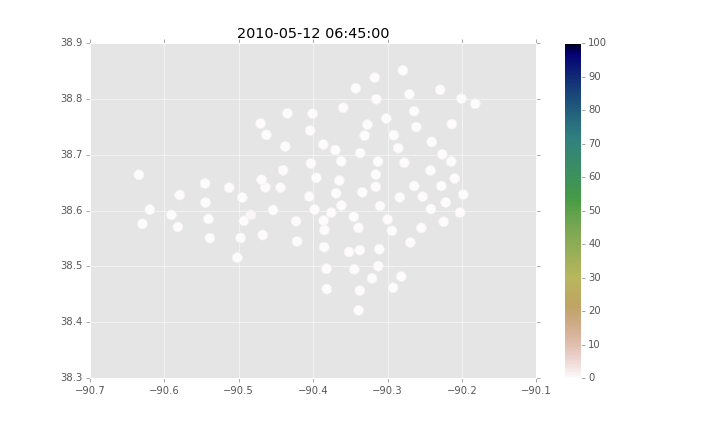
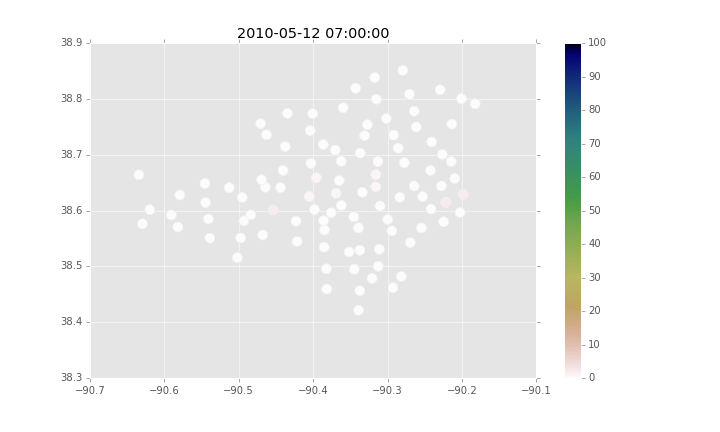
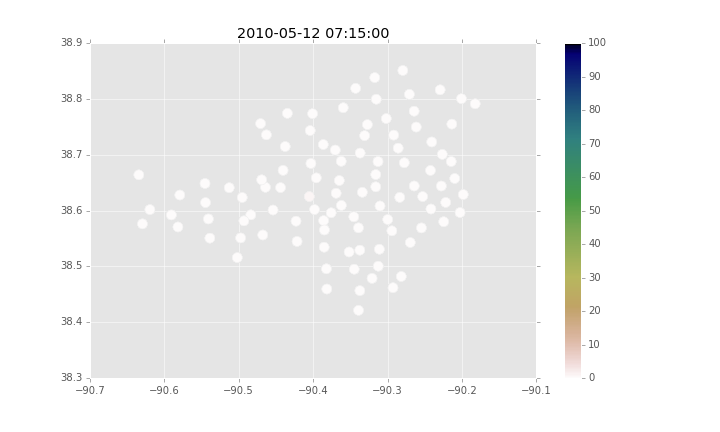
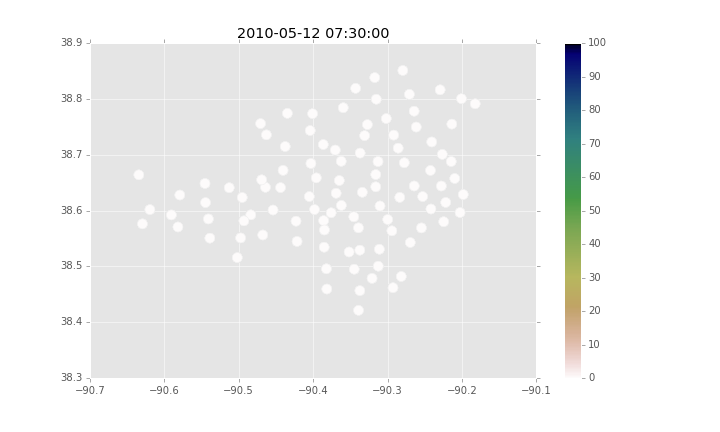
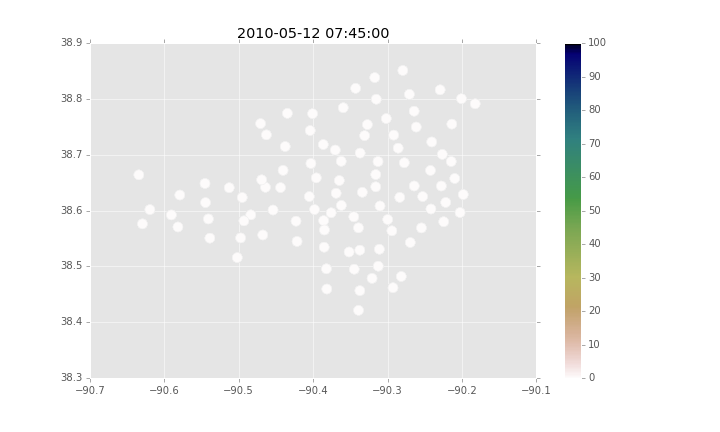
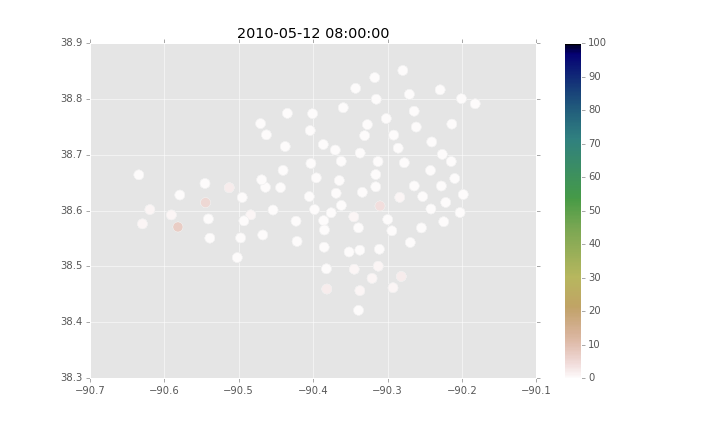
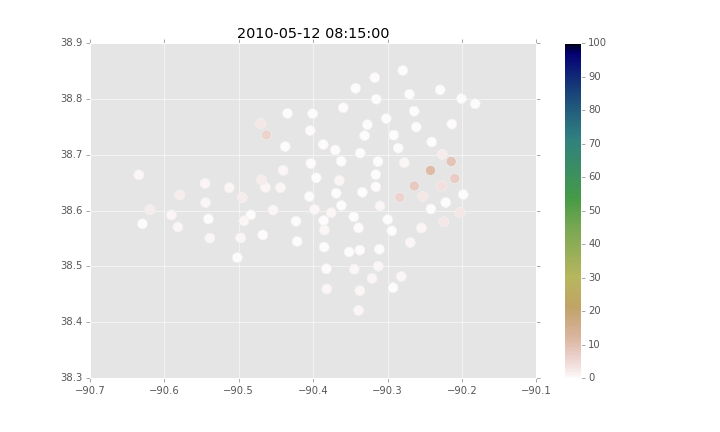
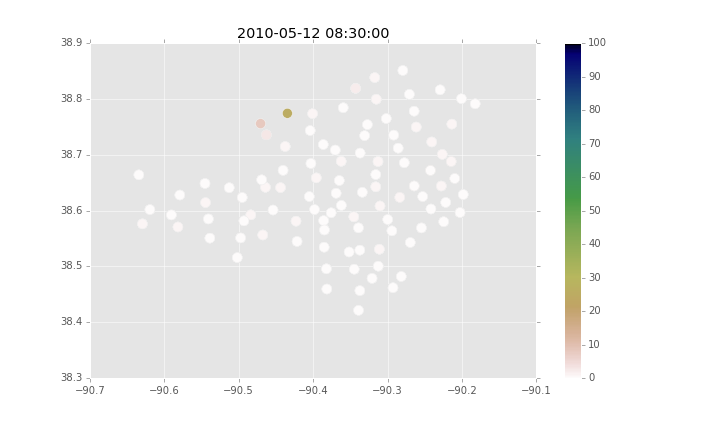
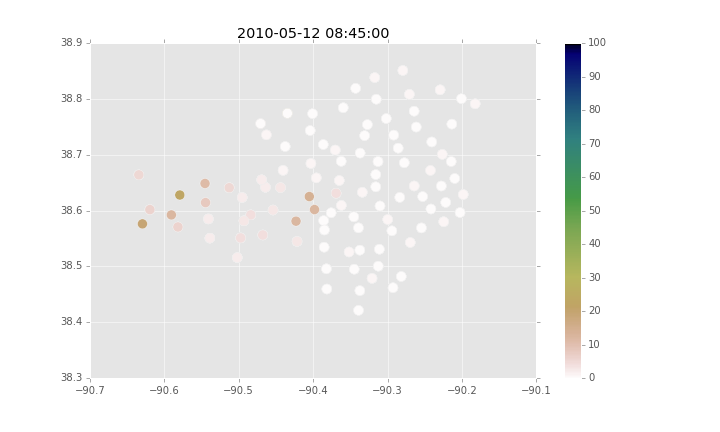
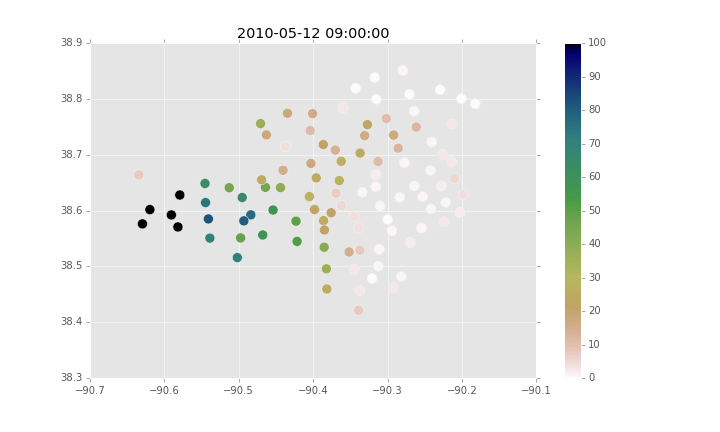
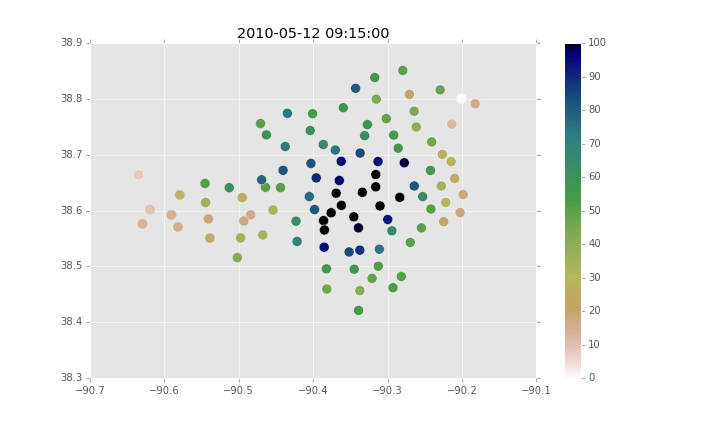
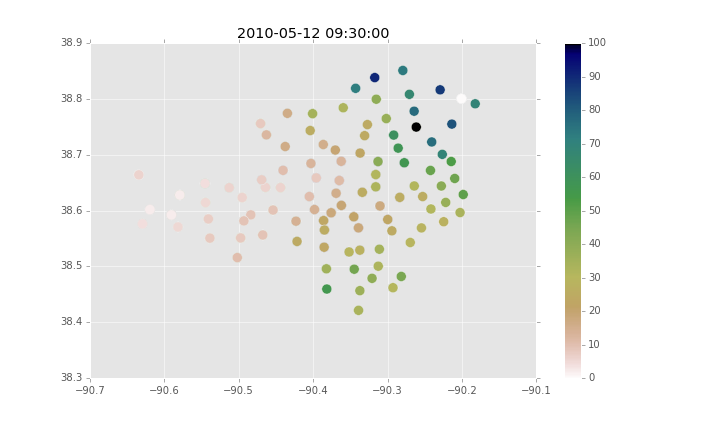
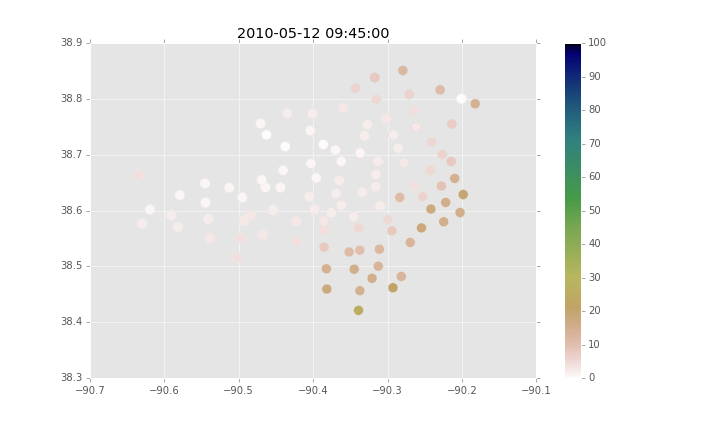
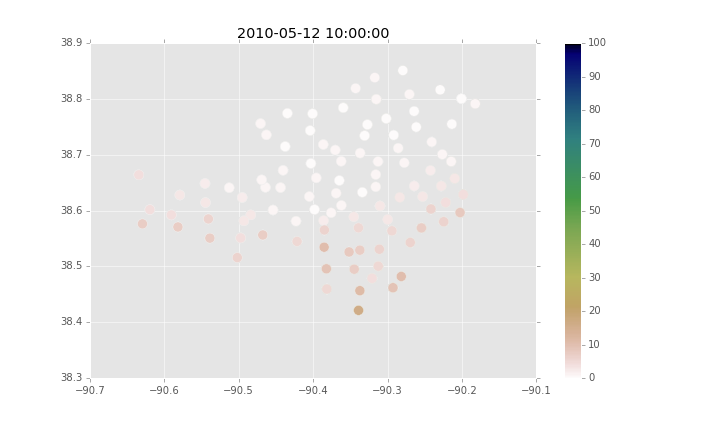
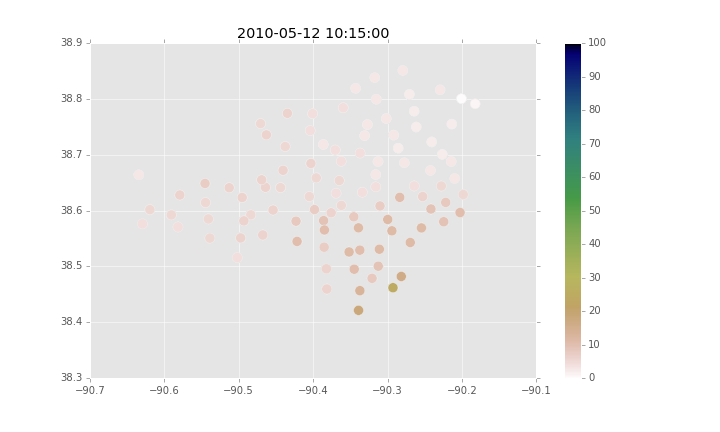

In [231]:
movie(z)

#### Import the r stuff

In [306]:
from rpy2.robjects import pandas2ri, r, globalenv
from rpy2.robjects.packages import STAP
pandas2ri.activate()

with open('SVG.r', 'r') as f:
    string = f.read()
rfuncs = STAP(string, "rfuncs")

In [240]:
def func(res, i, step=1, plot_v=True, plot_k=True, ax=None, animated=False):
    r_res = res[[0,1,2,3,4, i]].dropna(how='any')
    v = pandas2ri.ri2py(rfuncs.get_variogram(r_res))
    v1 = pandas2ri.ri2py(rfuncs.get_iSVG(r_res, 6, target_np=300, max_bnd=25))
    if plot_v:
        v.plot(x='dist', y='gamma', marker = 'o', figsize=(8,4))
        v1.plot(x='dist', y='gamma', marker = 'o', figsize=(8,4))

    model = 'Sph'
    psill = r_res.var()[4]
    for j in range(len(v)):
        if v.gamma[j] > psill:
            rng = v.dist[j]
            break
    k = pandas2ri.ri2py(rfuncs.get_krige(r_res, psill, model, rng, step=step))
   
    if plot_k:
        if not ax:
            fig, ax = plt.subplots()
        vmin = max(0, res[[i]].min().values[0])
        vmax = res[[i]].max().values[0]
        ax.scatter(k.x, k.y, c=k['var1.pred'], cmap='gist_earth_r', marker='s', edgecolors='none', s=step*300, vmin=vmin, vmax=vmax)
        scat = ax.scatter(res.X, res.Y, c=res[[i]], cmap='gist_earth_r', edgecolors='1', vmin=vmin, vmax=vmax)
        ax.set_xlim(0,70)
        ax.set_ylim(0,50)
        ax.set_title('{t} (range={dts}km)'.format(t=res.columns[i], dts=round(rng)))
        if animated:
            return scat
        plt.colorbar(scat)

[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]
[using ordinary kriging]



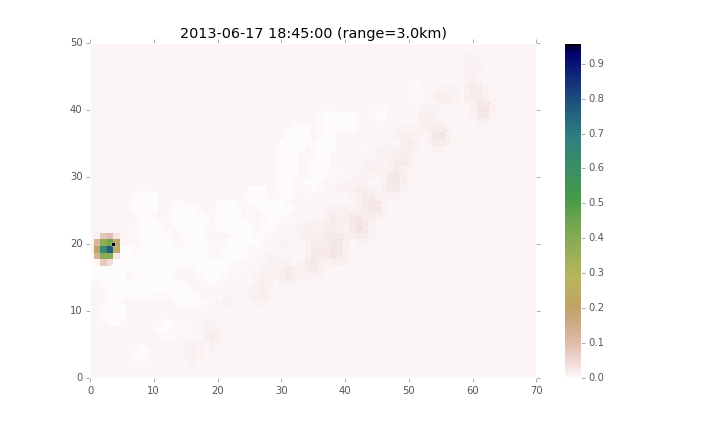
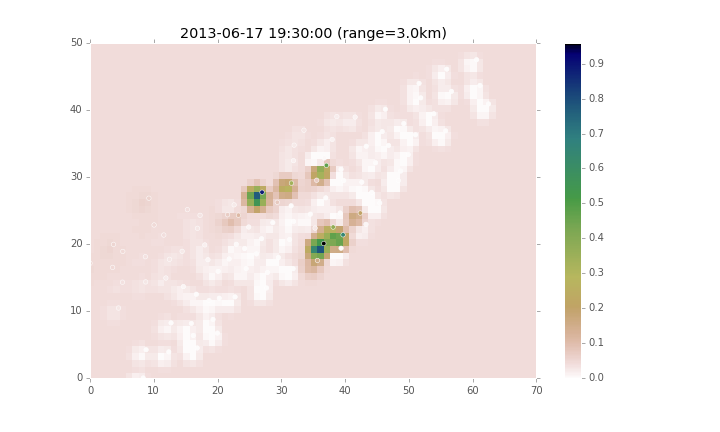
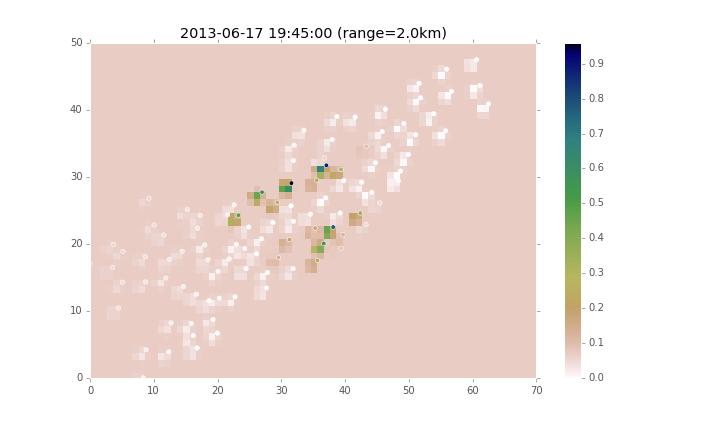
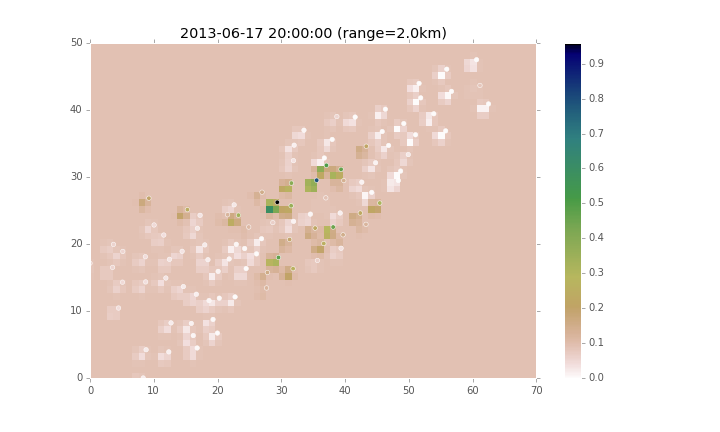
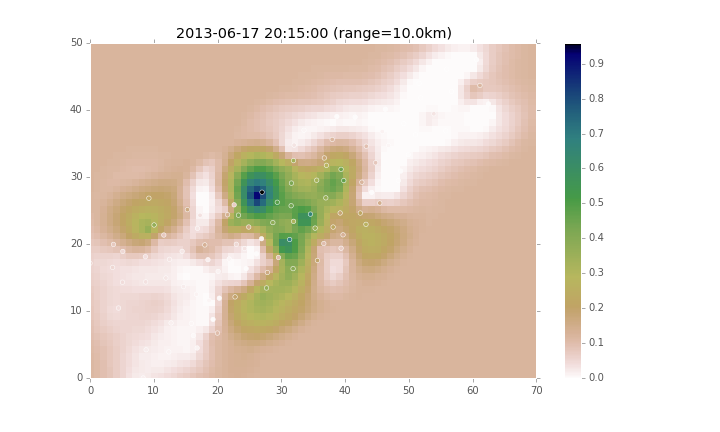
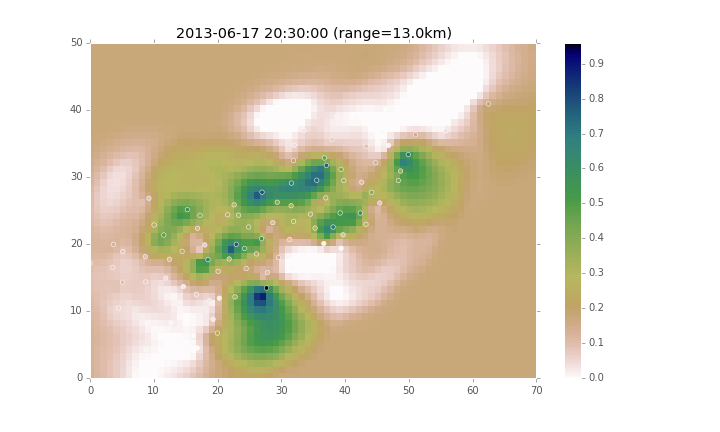
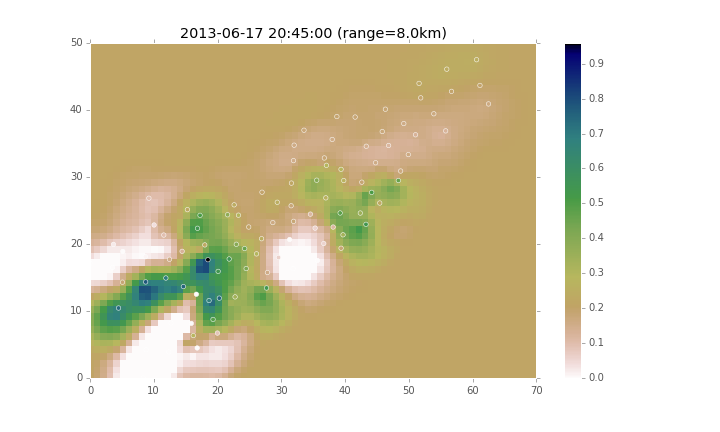
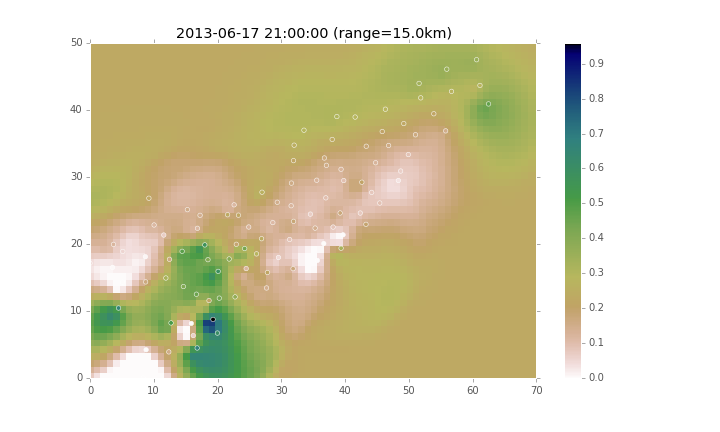
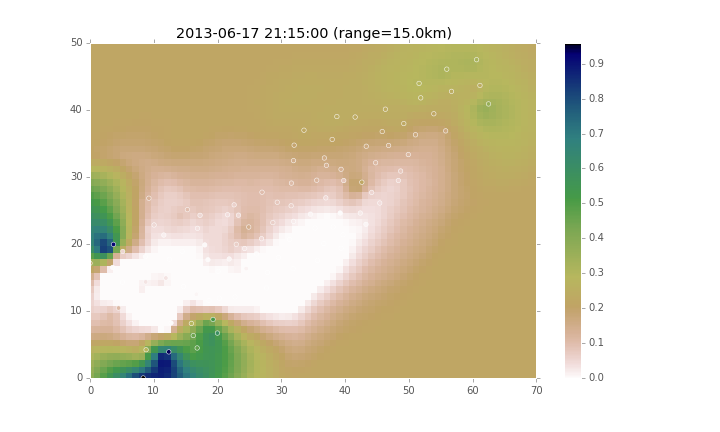
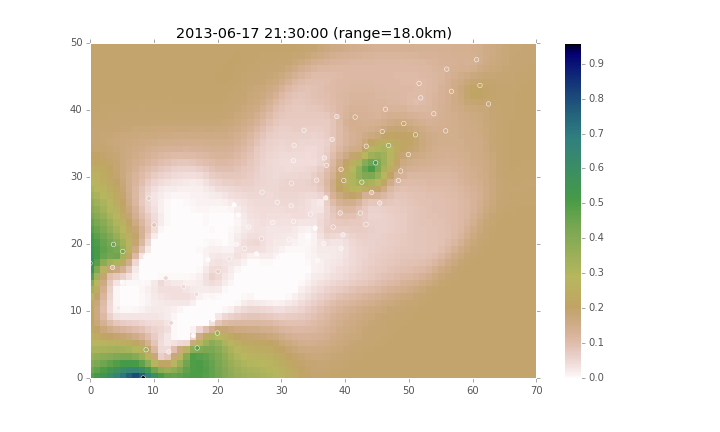
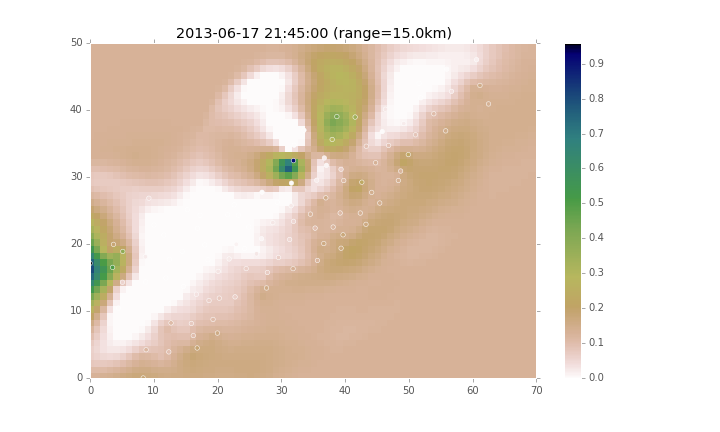
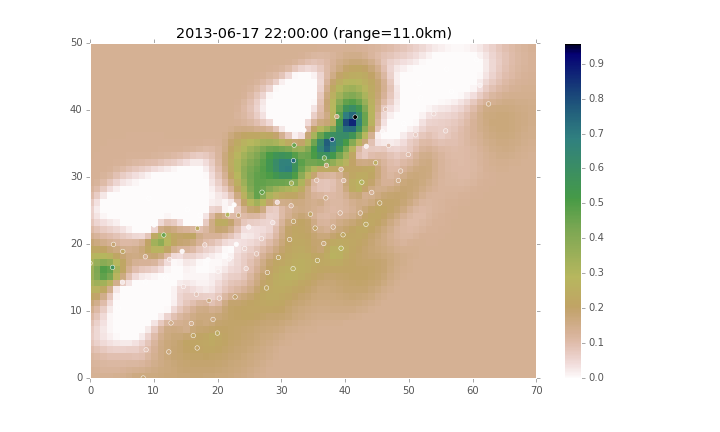
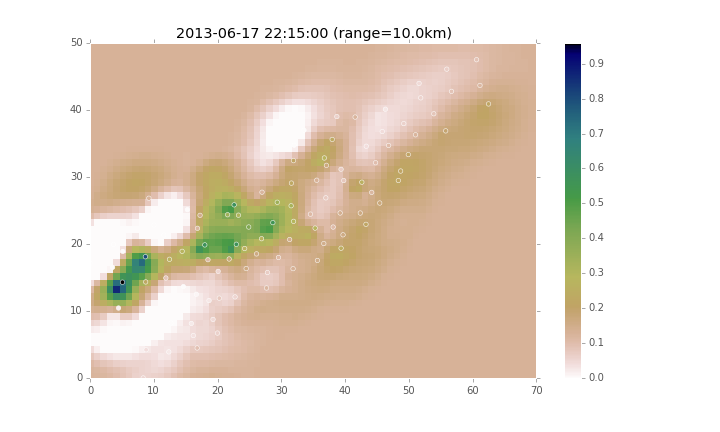
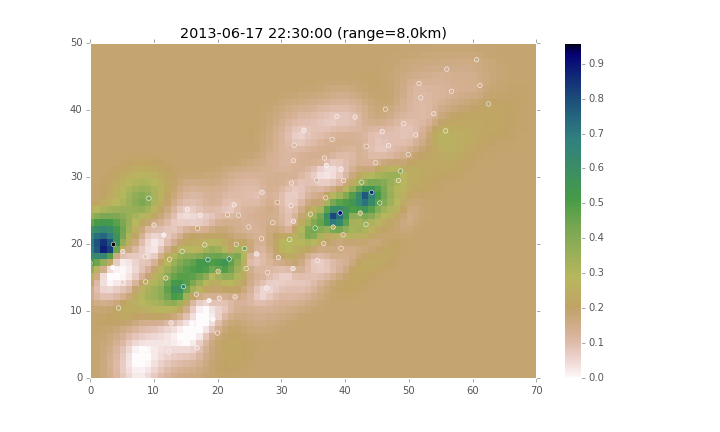
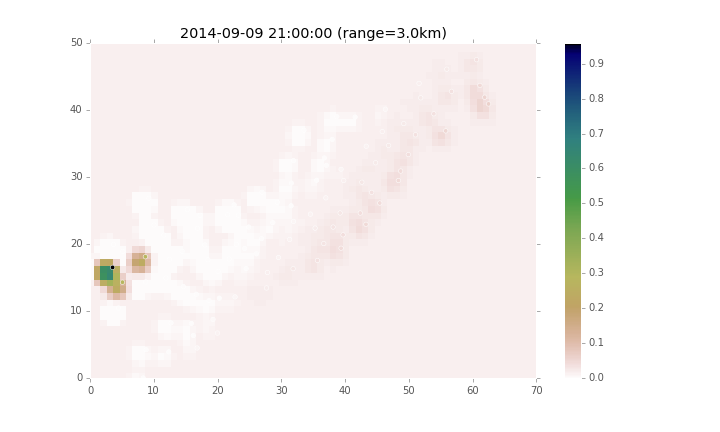
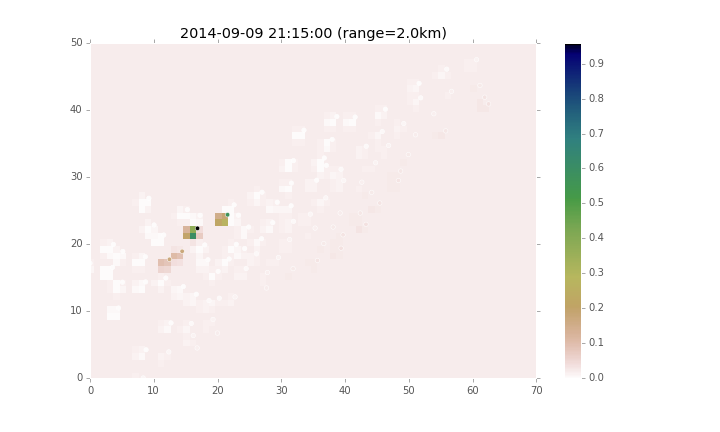
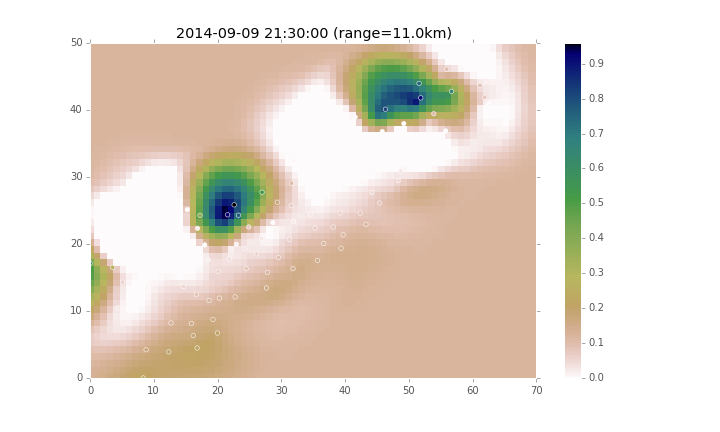
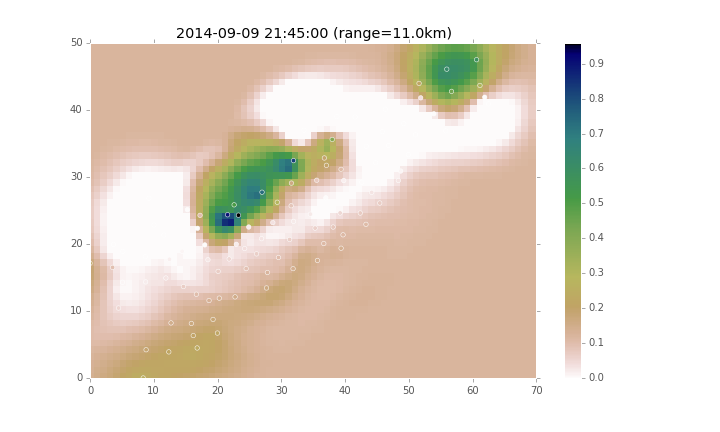
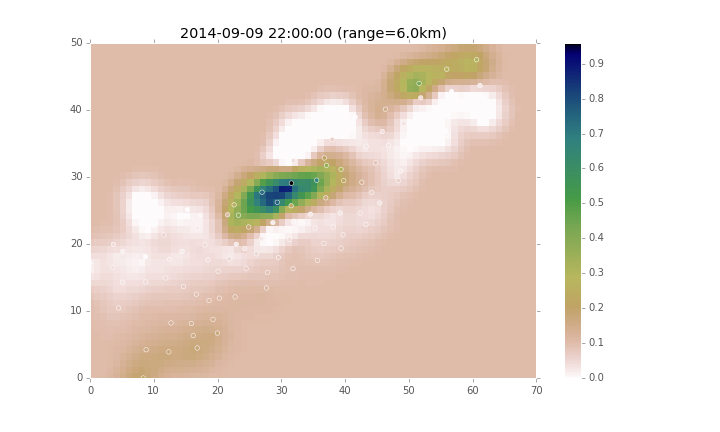
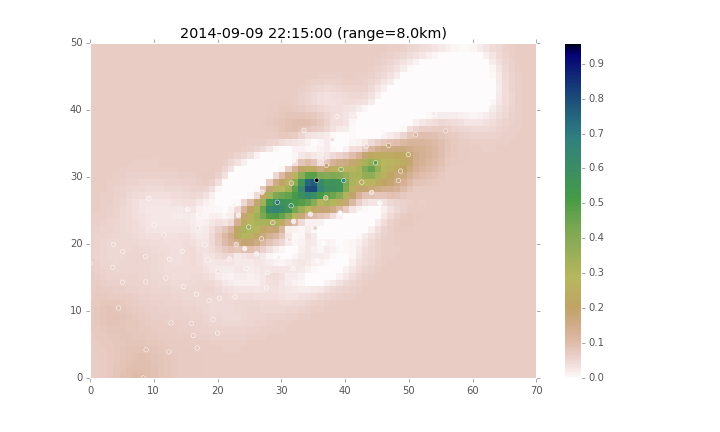
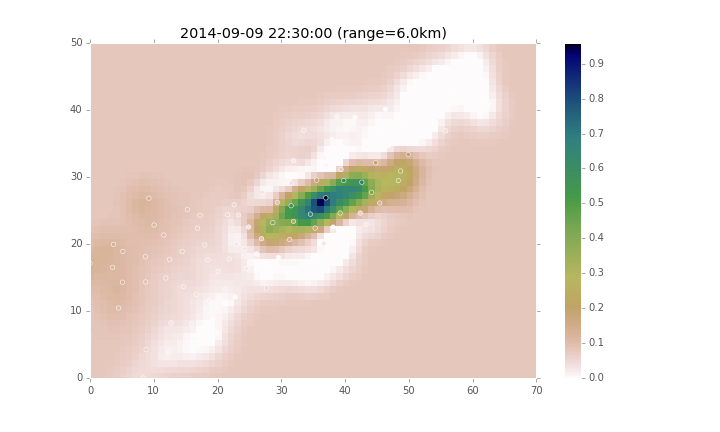
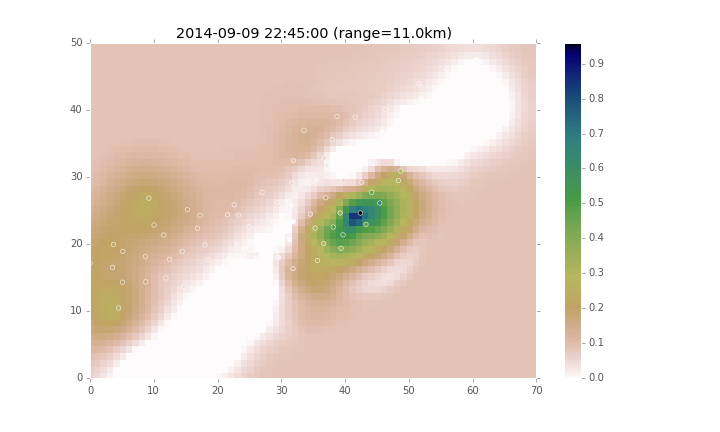
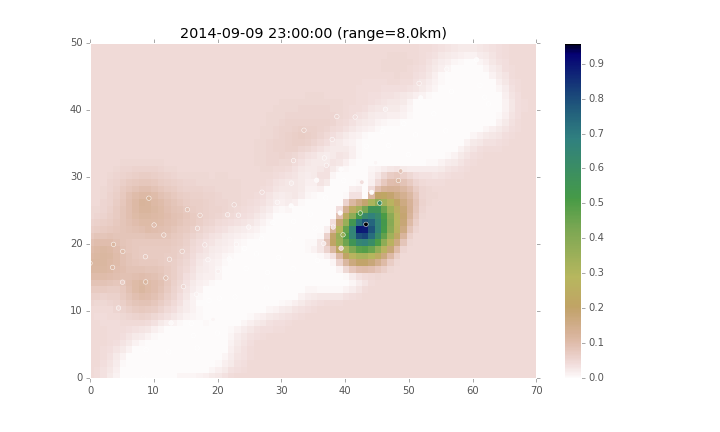
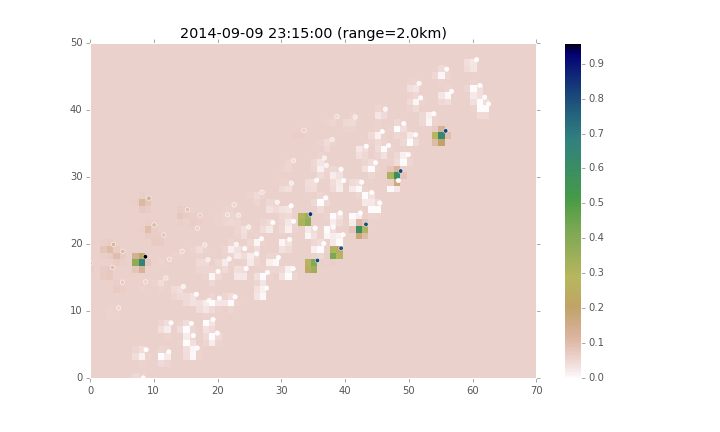
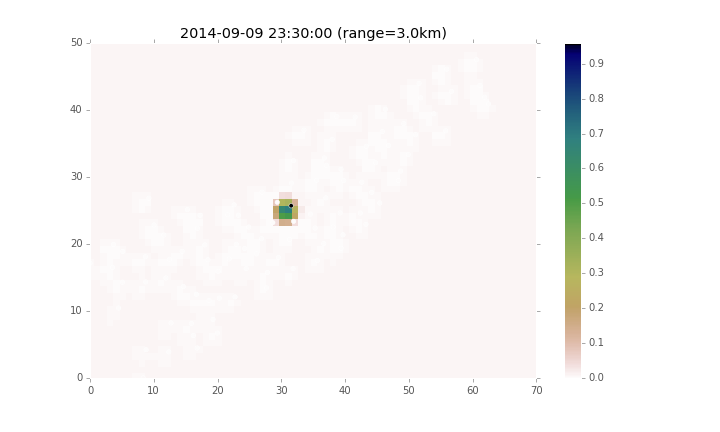
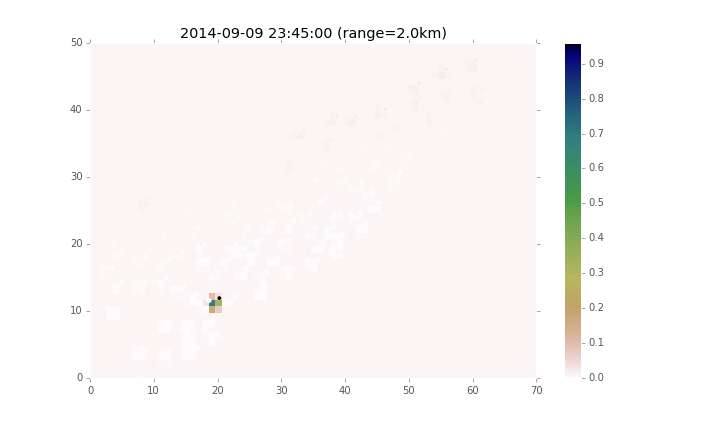
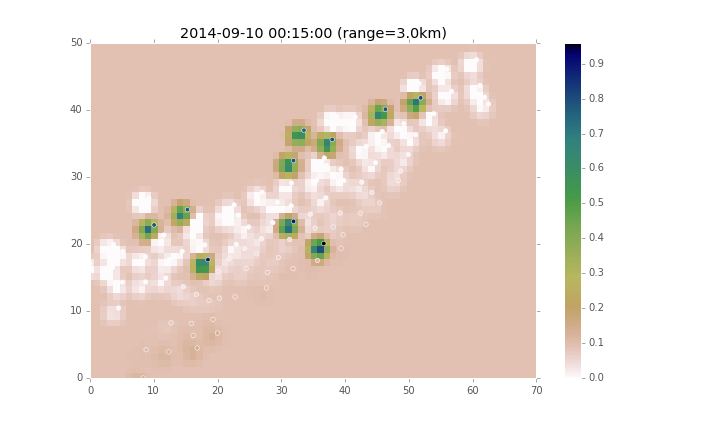
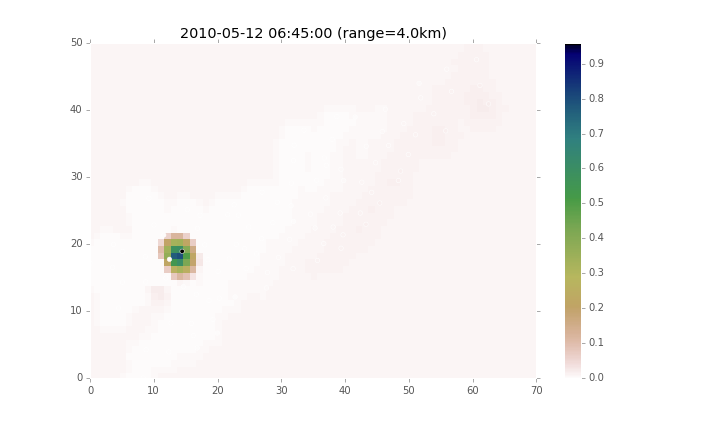
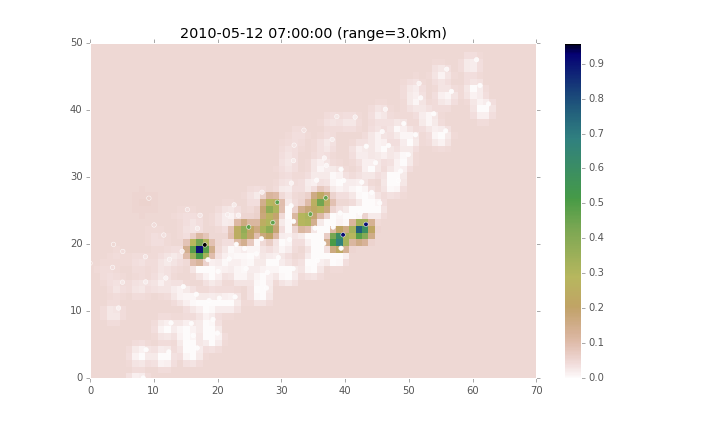
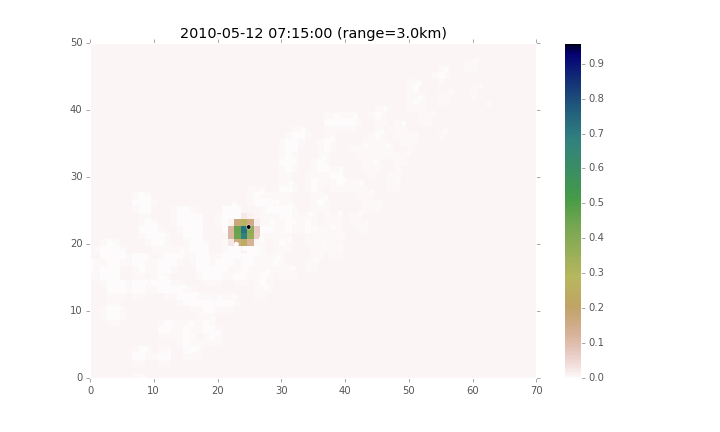
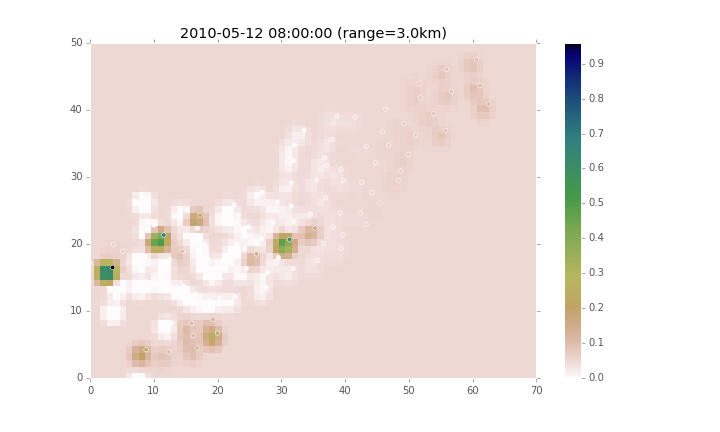
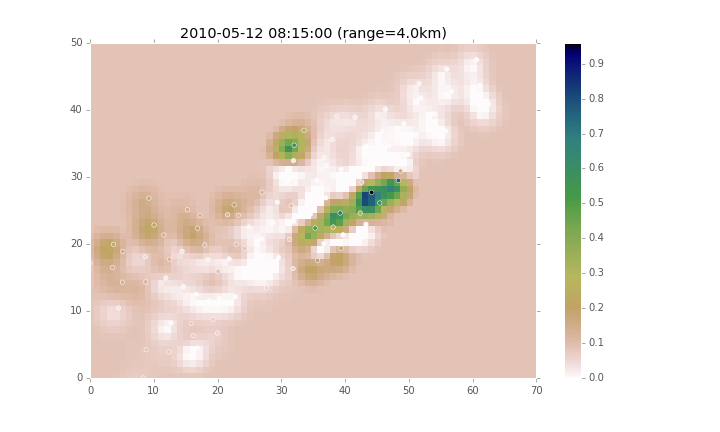
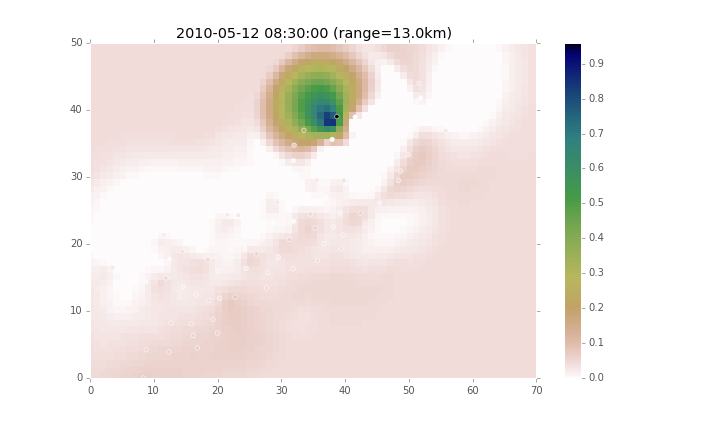
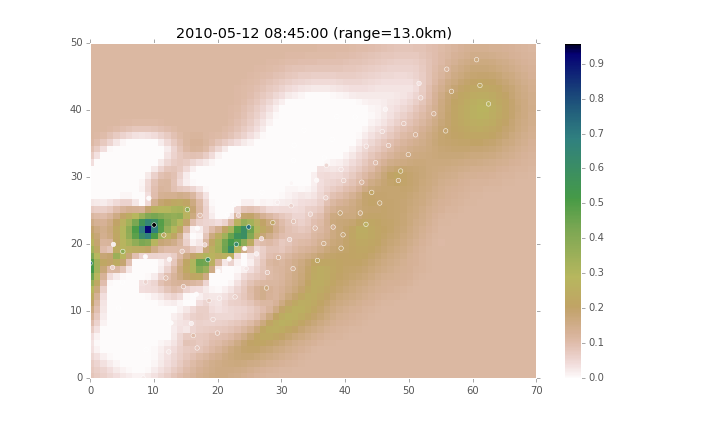
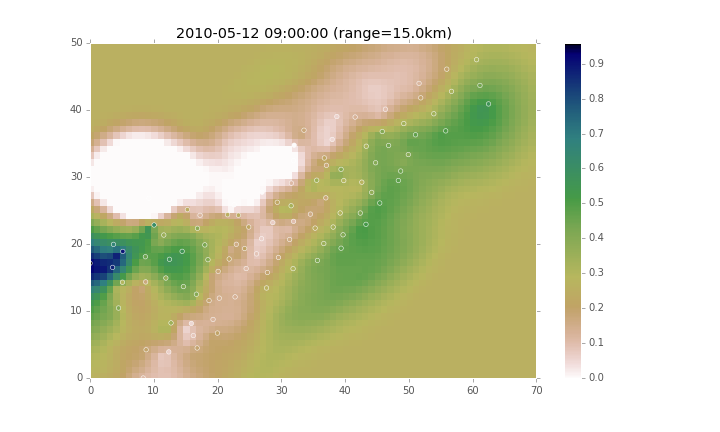
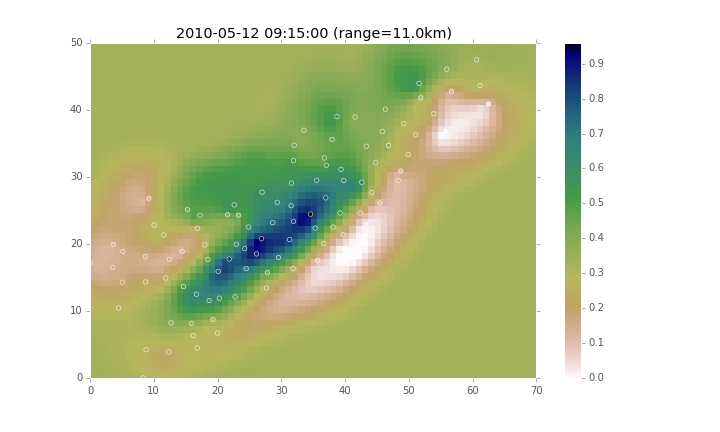
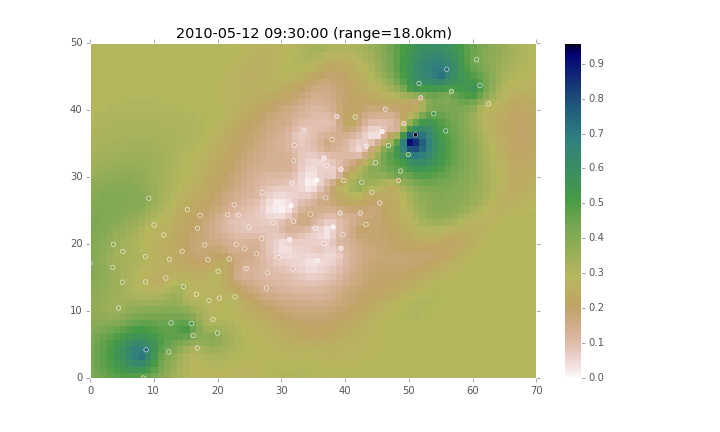
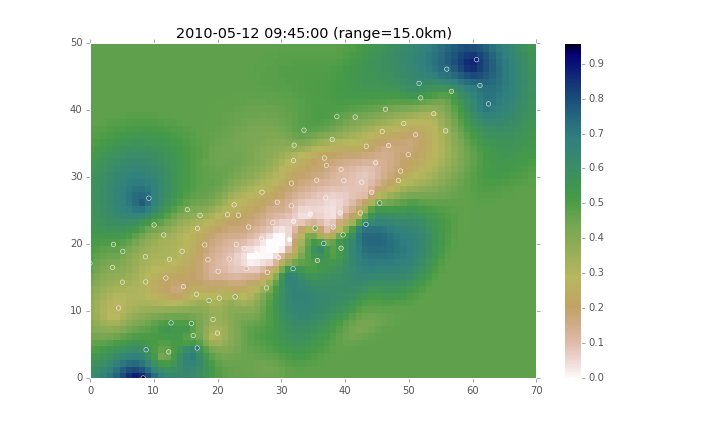
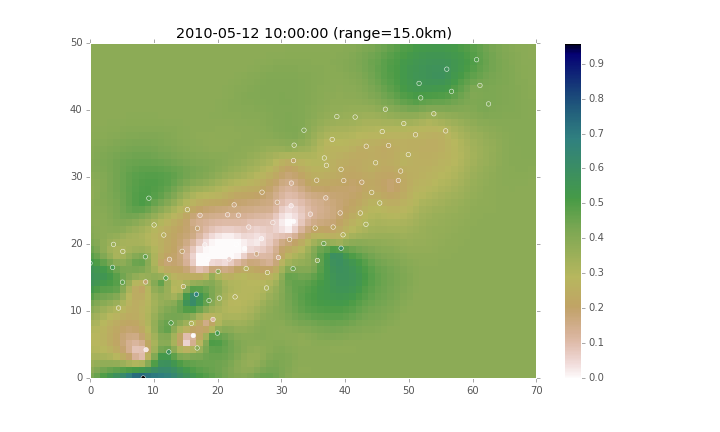
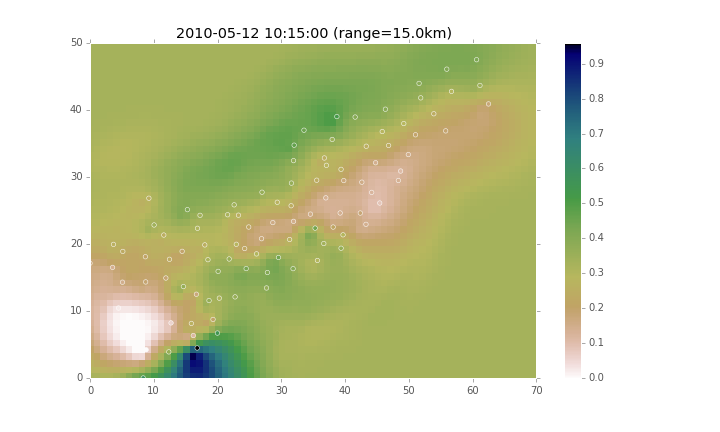

In [241]:
fig, ax = plt.subplots(1,1,figsize= (10,6))
sc = func(res, 5, plot_v=False, ax=ax, animated=True)
fig.colorbar(sc)

def animate(i):
    global res
    scat = func(res, i+5, plot_v=False, ax=ax, animated=True)
animation.FuncAnimation(fig, animate, frames=len(res.columns[5:]), interval=300, blit=True)

In [259]:
s = res.iloc[:,5:].unstack()

In [264]:
s.name = 'res'

In [266]:
s = rg.ll.join(s)

In [284]:
s = pd.DataFrame(data=s.values,columns = s.columns).dropna(how='any')
s.X = s.X -s.X.min()
s.Y = s.Y -s.Y.min()
